# Data Analysis
This notebook is used to analyze the data collected from live runs. It includes various visualizations and statistical analyses to understand the performance of the runner

## TOC:

## Load the Dataset and Perform any Preprocessing

In [1]:
from utilis.helper import extract_global_json, extract_json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [102]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
# add categorical weather conditions
def add_weather_conditions(df, flat):
    # Create categorical weather conditions based on continuous variables
    df['temp_category'] = pd.cut([flat['temp']] * len(df), 
                                  bins=[0, 15, 25, 35], 
                                  labels=['Cold', 'Moderate', 'Hot'])
    
    df['humidity_category'] = pd.cut([flat['humidity']] * len(df), 
                                      bins=[0, 40, 70, 100], 
                                      labels=['Low', 'Medium', 'High'])
    
    # Create time-based categories
    df['time_category'] = pd.cut(df['time_datetime'].dt.hour, 
                                bins=[0, 6, 12, 18, 24], 
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    return df
# =========
# Load all series
# =========
output_folder = extract_global_json('output_folder')
dataframes = []

# loop through each dataset
for folder_name in os.listdir(output_folder):
    csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
    json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")
    # get the csv_file into a DataFrame
    df = pd.read_csv(csv_file_path, parse_dates=["time_datetime"])
    overall_data = extract_json(json_file_path)

    df["series_id"] = folder_name  # Identify which series

    # Flatten weather dict if present
    flat = overall_data.copy()
    if "weather" in flat and isinstance(flat["weather"], dict):
        for k, v in flat["weather"].items():
            flat[f"{k}"] = v
        del flat["weather"]

    # add categorical weather conditions
    df = add_weather_conditions(df, flat)

    dataframes.append(df)

data = pd.concat(dataframes).sort_values(["series_id", "time_datetime"])

# Perform some basic preprocessing
# =========
# Encode series_id
# =========
# Define ordinal mappings with meaningful order
ordinal_mappings = {
    'temp_category': ['Cold', 'Moderate', 'Hot'],
    'humidity_category': ['Low', 'Medium', 'High'],
}


for col, categories in ordinal_mappings.items():
    if "category" in col and col in ordinal_mappings:
        encoder = OrdinalEncoder(categories=[categories]) 
        data[f"{col}_enc"] = encoder.fit_transform(data[[col]])

# Add date features (optional)
data["month"] = data["time_datetime"].dt.month
data["dayofweek"] = data["time_datetime"].dt.dayofweek
data["time_s"] = df.groupby("series_id")["time_datetime"].transform(lambda x: (x - x.iloc[0]).dt.total_seconds())


# Cumulative Elevtion Gain
data["cumulative_elevation_gain_m"] = data.groupby("series_id")["diff_altitude_mps"].transform(lambda x: x.clip(lower=0).cumsum()).fillna(0)

# Different smoothing techniques
window = 10
data["smooth_altitude_m"] = data.groupby("series_id")["altitude_m"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_heartrate_bps"] = data.groupby("series_id")["heartrate_bps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_velocity_mps"] = data.groupby("series_id")["velocity_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_cadence_rpm"] = data.groupby("series_id")["cadence_rpm"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_grade_percent"] = data.groupby("series_id")["grade_percent"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_headwind_mps"] = data.groupby("series_id")["headwind_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
data["smooth_crosswind_mps"] = data.groupby("series_id")["crosswind_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

data["diff_velocity_mps2"] = data.groupby("series_id")["smooth_velocity_mps"].transform(lambda x: x.diff())
data["diff_heartrate_bps2"] = data.groupby("series_id")["smooth_heartrate_bps"].transform(lambda x: x.diff())

# Shifted features
shift = 0
data["diff_velocity_mps2"] = data.groupby("series_id")["diff_velocity_mps2"].transform(lambda x: x.shift(shift))

C:\Users\katzr\AppData\Local\Temp\ipykernel_84568\140608514.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file_path, parse_dates=["time_datetime"])


## Try running time series cross-validation with external regressors

Training set size: 3583
Test set size: 1015
Test series_id: ['2025-07-05_12-32' '2025-08-06_20-43' '2025-08-08_18-48']

Starting hyperparameter tuning...

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'model__alpha': 1000.0, 'poly__degree': 2, 'poly__include_bias': False, 'poly__interaction_only': True, 'poly__order': 'C'}
Best CV score: -0.0101

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'model__alpha': 1000.0, 'poly__degree': 2, 'poly__include_bias': False, 'poly__interaction_only': True, 'poly__order': 'C'}

============ Train Dataset Evaluation ============
R² score for Train Dataset: 0.1953
MSE for Train Dataset: 0.0082
MAE for Train Dataset: 0.0533

============ Test Dataset Evaluation ============
R² score for Test Dataset: 0.1296
MSE for Test Dataset: 0.0077
MAE for Test Dataset: 0.0577


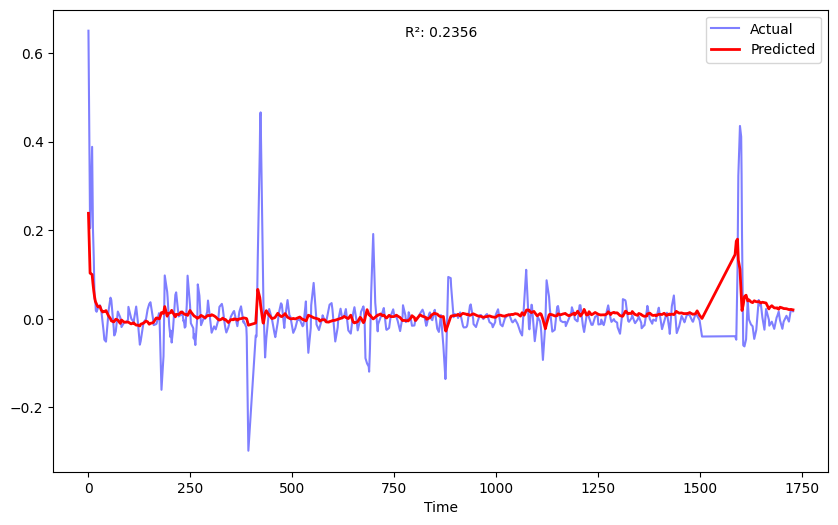

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import GroupShuffleSplit, TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class RidgeRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make sklearn Ridge compatible with sklearn Pipeline"""
    def __init__(self, alpha=1.0):
        self.model_ = None
        self.feature_count_ = None
        self.alpha = alpha

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        self.model_ = Ridge(alpha=self.alpha).fit(X, y)
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class LinearRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make sklearn LinearRegression compatible with sklearn Pipeline"""
    def __init__(self):
        self.model_ = None
        self.feature_count_ = None

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        self.model_ = LinearRegression().fit(X, y)
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class OLSRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make statsmodels OLS compatible with sklearn Pipeline"""
    def __init__(self):
        self.model_ = None
        self.feature_count_ = None

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        # Add constant for intercept
        X_with_const = add_constant(X, has_constant='add')
        self.model_ = OLS(y, X_with_const).fit()
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
            
        # Add constant for intercept
        X_with_const = add_constant(X, has_constant='add')
        return self.model_.predict(X_with_const)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

# initialize value name and features
features=["distance_m", 
          "smooth_heartrate_bps",
          "smooth_velocity_mps",
        #   "stride_length_m", 
          "smooth_altitude_m", 
          "diff_altitude_mps", 
          "smooth_headwind_mps", 
          "smooth_crosswind_mps", 
          "smooth_grade_percent",
          "temp_category_enc",
          "cumulative_elevation_gain_m",
        #   "humidity_category_enc",
        #   "pace_efficiency",
        #   "day_category",
        #   "series_id_enc",
        #   "temp",
        #   "hum",
        #   "month",
        #   "dayofweek"
          ]
# ]
# value = "smooth_velocity_mps"
# value = "diff_velocity_mps2"
value = "diff_heartrate_bps2"
# value = "smooth_cadence_rps"

# Drop rows with NaNs from lagging
data = data.dropna()

# data["series_id_enc"] = encoder.fit_transform(data[["series_id"]])

# =========
# Define features & target
# =========
X = data[features]
y = data[value]

# =========
# Train/test split (time order preserved)
# =========
# use stratified split to ensure series_id distribution
# Split by series_id to avoid data leakage 
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data['series_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Test series_id: {data.iloc[test_idx]['series_id'].unique()}\n")

# =========
# Polynomial regression pipeline
# =========
poly_degree = 2  # try 2 or 3
pipeline = Pipeline([
    # ("scaler", StandardScaler()),
    # ("scaler", MinMaxScaler()),
    ("scaler", RobustScaler()),
    # ("scaler", PowerTransformer()),
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
    # ("model", LinearRegressor())
    ("model", RidgeRegressor(alpha=1.0))
    # ("model", OLSRegressor())
])

# =========
# Hyperparameter tuning
# =========
# # Different scalers to try
# scalers = [
#     ('standard', StandardScaler()),
#     ('minmax', MinMaxScaler()),
#     # ('robust', RobustScaler()),
#     # ('power', PowerTransformer())
# ]
# Tune hyperparameters specifically for your target
param_grid = {
    'model__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    # 'model__fit_intercept': [True, False],
    'poly__degree': [2, 3],
    'poly__interaction_only': [True, False],
    'poly__include_bias': [True, False],
    'poly__order': ['C', 'F'],  # Memory layout order
    # 'scaler': scalers  # Use different scalers
}


# Use time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1  # Add this to see progress
)

print("Starting hyperparameter tuning...\n")
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}\n")

# Use the best estimator for final evaluation
best_pipeline = grid_search.best_estimator_

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}\n")

# Use the best estimator for final evaluation
best_pipeline = grid_search.best_estimator_

best_pipeline.fit(X_train, y_train)

# =========
# Evaluate
# =========

print("============ Train Dataset Evaluation ============")
r2_train, mse_train, mae_train = best_pipeline.score(X_train, y_train)
print(f"R² score for Train Dataset: {r2_train:.4f}")
print(f"MSE for Train Dataset: {mse_train:.4f}")
print(f"MAE for Train Dataset: {mae_train:.4f}")

print("\n============ Test Dataset Evaluation ============")
r2_test, mse_test, mae_test = best_pipeline.score(X_test, y_test)
print(f"R² score for Test Dataset: {r2_test:.4f}")
print(f"MSE for Test Dataset: {mse_test:.4f}")
print(f"MAE for Test Dataset: {mae_test:.4f}")


# test date
# test = "2025-07-05_12-32"
# test = "2025-07-22_19-40"
# test = "2025-07-31_20-07"
# test = "2025-08-02_18-02"
# test = "2025-08-06_20-14"
# test = "2025-08-06_20-43"
test = "2025-08-08_18-48"
# plot actual vs predicted
y_pred = best_pipeline.predict(data[data["series_id"] == test][features])
model = best_pipeline.named_steps["model"]
# print(model.model_.summary())  # Rich statistical output
x = "time_s"
# x = "distance_m"
plt.figure(figsize=(10, 6))
plt.plot(data[data["series_id"] == test][x], data[data["series_id"] == test][value], label="Actual", color="blue", alpha=0.5)
plt.plot(data[data["series_id"] == test][x], y_pred, label="Predicted", color="red", linewidth=2)
plt.text(0.5, 0.95, f"R²: {r2_score(data[data['series_id'] == test][value], y_pred):.4f}", ha='center', va='center', transform=plt.gca().transAxes)
plt.xlabel("Time") 
plt.legend()
plt.show()


### Neural Network

Training set size: 4025
Validation set size: 1007
Test set size: 986
Training Simple Neural Network...
Epoch 1/60


c:\Users\katzr\Desktop\University\Projects\Marathon_Simulation\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1267 - mae: 0.2498 - val_loss: 0.0099 - val_mae: 0.0608 - learning_rate: 0.0010
Epoch 2/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - mae: 0.1163 - val_loss: 0.0093 - val_mae: 0.0550 - learning_rate: 0.0010
Epoch 3/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mae: 0.0850 - val_loss: 0.0090 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 4/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - mae: 0.0700 - val_loss: 0.0087 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 5/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - mae: 0.0635 - val_loss: 0.0084 - val_mae: 0.0517 - learning_rate: 0.0010
Epoch 6/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mae: 0.0602 - val_loss: 0.0082 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 7/60
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - mae: 0.0577 - val_loss: 0.0080 - val_mae: 0.0500 - learning_rate: 0.0010
Epoch 8/60
126/12

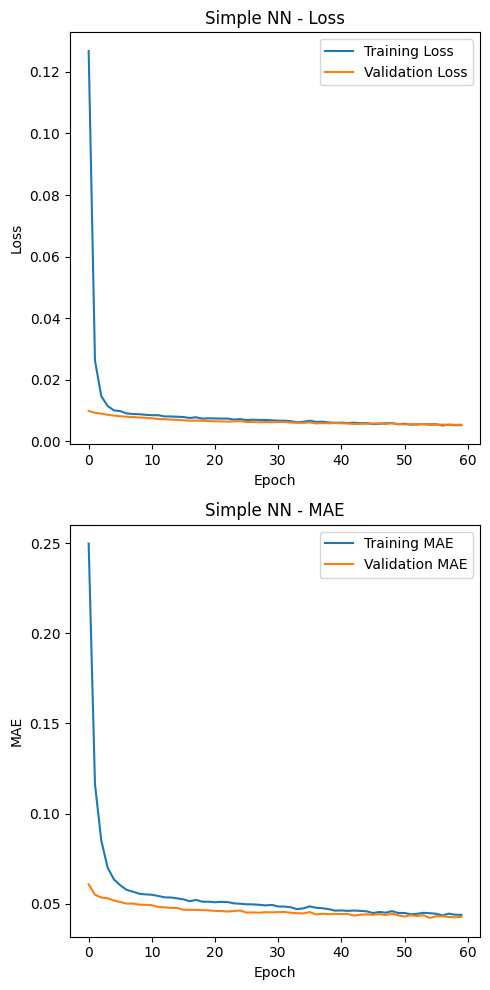

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =========
# Model 1: Simple Feedforward Neural Network
# =========
def create_simple_nn(input_dim):
    model = keras.Sequential([
        # layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        
        # layers.Dense(64, activation='relu'),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        
        # layers.Dense(32, activation='relu'),
        # layers.Dropout(0.2),
        
        # layers.Dense(16, activation='relu'),
        # layers.Dense(1)  # Output layer for regression
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    # Use a different optimizer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss='huber', # More robust to outliers than MSE
                  metrics=['mae'])
    return model

features=["distance_m", 
          "smooth_heartrate_bps",
          "smooth_velocity_mps",
          "stride_length_m", 
          "smooth_altitude_m", 
          "diff_altitude_mps", 
          "smooth_headwind_mps", 
          "smooth_crosswind_mps", 
          "smooth_grade_percent",
          "cumulative_elevation_gain_m",
          "temp_category_enc",
          "humidity_category_enc",
        #   "pace_efficiency",
        #   "day_category",
        #   "series_id_enc",
        #   "month",
        #   "dayofweek"
          ]


# =========
# Train/Test Split (Group-based to avoid data leakage)
# =========
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data['series_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Further split training into train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

models = {}
histories = {}

# 1. Simple Neural Network
print("Training Simple Neural Network...")
simple_nn = create_simple_nn(X_train_scaled.shape[1])
simple_nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)

history_simple = simple_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

models['Simple NN'] = simple_nn
histories['Simple NN'] = history_simple

# =========
# Model Evaluation
# =========
print("\n" + "="*60)
print("NEURAL NETWORK MODEL EVALUATION")
print("="*60)

results = {}

for name, model in models.items():
    if name == 'LSTM':
        # Handle LSTM predictions differently
        continue
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
    y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
    y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results[name] = {
        'train_r2': train_r2, 'val_r2': val_r2, 'test_r2': test_r2,
        'train_rmse': train_rmse, 'val_rmse': val_rmse, 'test_rmse': test_rmse,
        'predictions': y_test_pred
    }
    
    print(f"\n{name} Results:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Val R²:   {val_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.6f}")

# =========
# Visualizations
# =========
# Training history plots
fig, axes = plt.subplots(2, len(histories), figsize=(5*len(histories), 10))
if len(histories) == 1:
    axes = axes.reshape(-1, 1)

for i, (name, history) in enumerate(histories.items()):
    # Loss plot
    axes[0, i].plot(history.history['loss'], label='Training Loss')
    axes[0, i].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, i].set_title(f'{name} - Loss')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].legend()
    
    # MAE plot
    axes[1, i].plot(history.history['mae'], label='Training MAE')
    axes[1, i].plot(history.history['val_mae'], label='Validation MAE')
    axes[1, i].set_title(f'{name} - MAE')
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel('MAE')
    axes[1, i].legend()

plt.tight_layout()
plt.show()